In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
from random import randrange
# from torchsummary import summary
import os
import datetime

import sys

In [2]:
testset = torch.load('../data/testset_10steps_4ch.pt')

In [3]:
testloader = DataLoader(testset, batch_size=1, shuffle=True)

In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Input size: [batch, 3, 100, 100]
        # Output size: [batch, 3, 100, 100]
        self.encoder = nn.Sequential(
            nn.Conv2d(4, 32, 5, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 32, 5, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 32, 5, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 3, 5, stride=1, padding=1),
        )

    def forward(self, x):
        # print(x.size())
        wall = x[:, -1]
        # print(wall.size())
        x = self.encoder(x)
        x = self.decoder(x)
        # print(x.size())
        x = torch.cat((x, wall.reshape(len(x), 1, width_fig, width_fig)), 1)
        # print(x.size())
        return x

In [5]:
class StepAE(nn.Module):
    def __init__(self):
        """Variational Auto-Encoder Class"""
        super(StepAE, self).__init__()
        
        self.enc = Autoencoder()

    def step(self, x): # For actual run after training
        x = self.enc(x)
        return x

    def forward(self, x): # For training
        # Encode x to z
        recon1 = self.enc(x)
        recon2 = self.enc(recon1)
        recon3 = self.enc(recon2)
        recon4 = self.enc(recon3)
        # recon5 = self.enc(recon4)
        
        return recon1, recon2, recon3, recon4

In [37]:
def figplot():
    model_origin.eval()
    dataiter = iter(testloader)
    images, _, _, _, _, _, _, _, _, _ = dataiter.next()
    del _

    recon = model_origin.step(images.permute(0, 3, 1, 2).cuda())

    # del _
    torch.cuda.empty_cache()
    # get sample outputs

    steps = 200
    skip = int(steps/10)
    
    plt.figure(figsize=(6, 24))
    ax=plt.subplot(12,1,1)
    plt.imshow(images.permute(0,3,1,2).view(1,4,100,100).cpu()[0][:-1].permute(1,2,0))
    ax=plt.subplot(12,1,2)
    output = recon.detach().view(1, 4, 100, 100).cpu()[0][:-1].permute(1,2,0)
    plt.imshow(output)
    ii = 0
    for i in range(steps):
        recon = model_origin.step(recon)
        # del _
        
        if i%skip == 0:
            ii+=1
            ax = plt.subplot(12, 1, ii + 2)
            # print(i)
            # output is resized into a batch of iages
            # use detach when it's an output that requires_grad
            output = recon.detach().view(1, 4, 100, 100).cpu()[0][:-1].permute(1, 2, 0)
            # print(output.min(), output.max())
            plt.imshow(output)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            del output
            torch.cuda.empty_cache()
    # plt.savefig("../data/model/"+timestampStr+"/fig_{}_{}.png".format(epochnow, step))
    # torch.save(images, "../data/model/"+timestampStr+"/input_{}_{}.pt".format(epochnow,step))
    del images
    del recon
    del dataiter

In [12]:
width_fig = 100

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_origin = StepAE().to(device)
model_origin.load_state_dict(torch.load("latest_net_wdisc_4ch.pt"))

<All keys matched successfully>

In [9]:
model_origin.eval()

StepAE(
  (enc): Autoencoder(
    (encoder): Sequential(
      (0): Conv2d(4, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01)
    )
    (decoder): Sequential(
      (0): ConvTranspose2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): ConvTranspose2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    )
  )
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

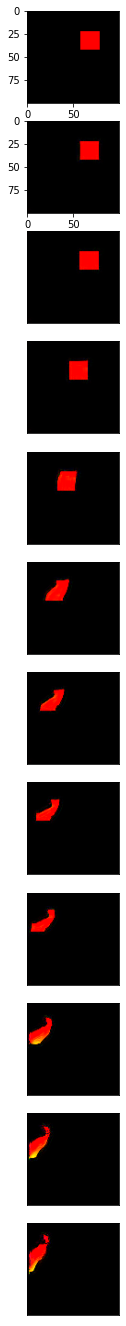

In [72]:
figplot()